In [31]:
from transformers import GPT2Model
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2Model, GPT2Config

# Load the model configuration and model itself
config = GPT2Config()
model = GPT2Model(config)

# Load the pre-trained GPT-2 model
# model = GPT2Model.from_pretrained('gpt2')

print(model.h[0].attn.num_heads)

print(model.h[0])

12
GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [32]:
# Define a function to extract weights
def extract_attention_weights(model, layer_idx):
    attention = model.h[layer_idx].attn

    # combined weight matrix for Q, K, V
    combined_weight_matrix = attention.c_attn.weight

    # Extract individual matrices
    all_heads = combined_weight_matrix.view(config.num_attention_heads, -1, config.n_embd)
    W_q, W_k, W_v = all_heads.chunk(3, dim=1)

    # Output weights
    W_o = attention.c_proj.weight

    return W_q, W_k, W_v, W_o



In [33]:
# Select the layer and head
layer_idx = 0  # For example, the first layer


In [7]:
# Extract the weights
attention_head = model.h[layer_idx].attn
weights = attention_head.c_attn.weight

# The weights for the specific head
head_weights = weights.view(config.num_attention_heads, -1, config.n_embd)
head_weights.shape

torch.Size([12, 192, 768])

In [41]:
W_q, W_k, W_v, W_o = extract_attention_weights(model, layer_idx)

# Now, W_q, W_k, W_v, and W_o contain the weights for each head in the specified layer
print(f"W_q shape: {W_q.shape}")
print(f"W_k shape: {W_k.shape}")
print(f"W_o shape: {W_o.shape}")
print(f"W_v shape: {W_v.shape}")

W_q shape: torch.Size([12, 64, 768])
W_k shape: torch.Size([12, 64, 768])
W_o shape: torch.Size([768, 768])
W_v shape: torch.Size([12, 64, 768])


In [42]:
# Define the dimensions
num_heads = 12
head_size = 64
d_model = 768

# Compute W_qk and W_ov for each head
W_qk = torch.empty((num_heads, head_size, head_size))
# W_ov = torch.empty((num_heads, d_model, head_size))

for i in range(num_heads):
    W_qk[i] = torch.matmul(W_q[i], W_k[i].T) / np.sqrt(d_model)
    # W_ov[i] = torch.matmul(W_o, W_v[i].T)

# Now we'll calculate the eigenvalues for each W_qk and W_ov
eigenvalues_qk = torch.empty((num_heads, head_size))
# eigenvalues_ov = torch.empty((num_heads, head_size))

for i in range(num_heads):
    eigenvalues_qk[i] = torch.linalg.eigvals(W_qk[i]).abs()
    # eigenvalues_ov[i] = torch.linalg.eigvals(W_ov[i]).abs()

# Log-scale the eigenvalues
eigenvalues_qk_log = torch.log(eigenvalues_qk)
# eigenvalues_ov_log = torch.log(eigenvalues_ov)


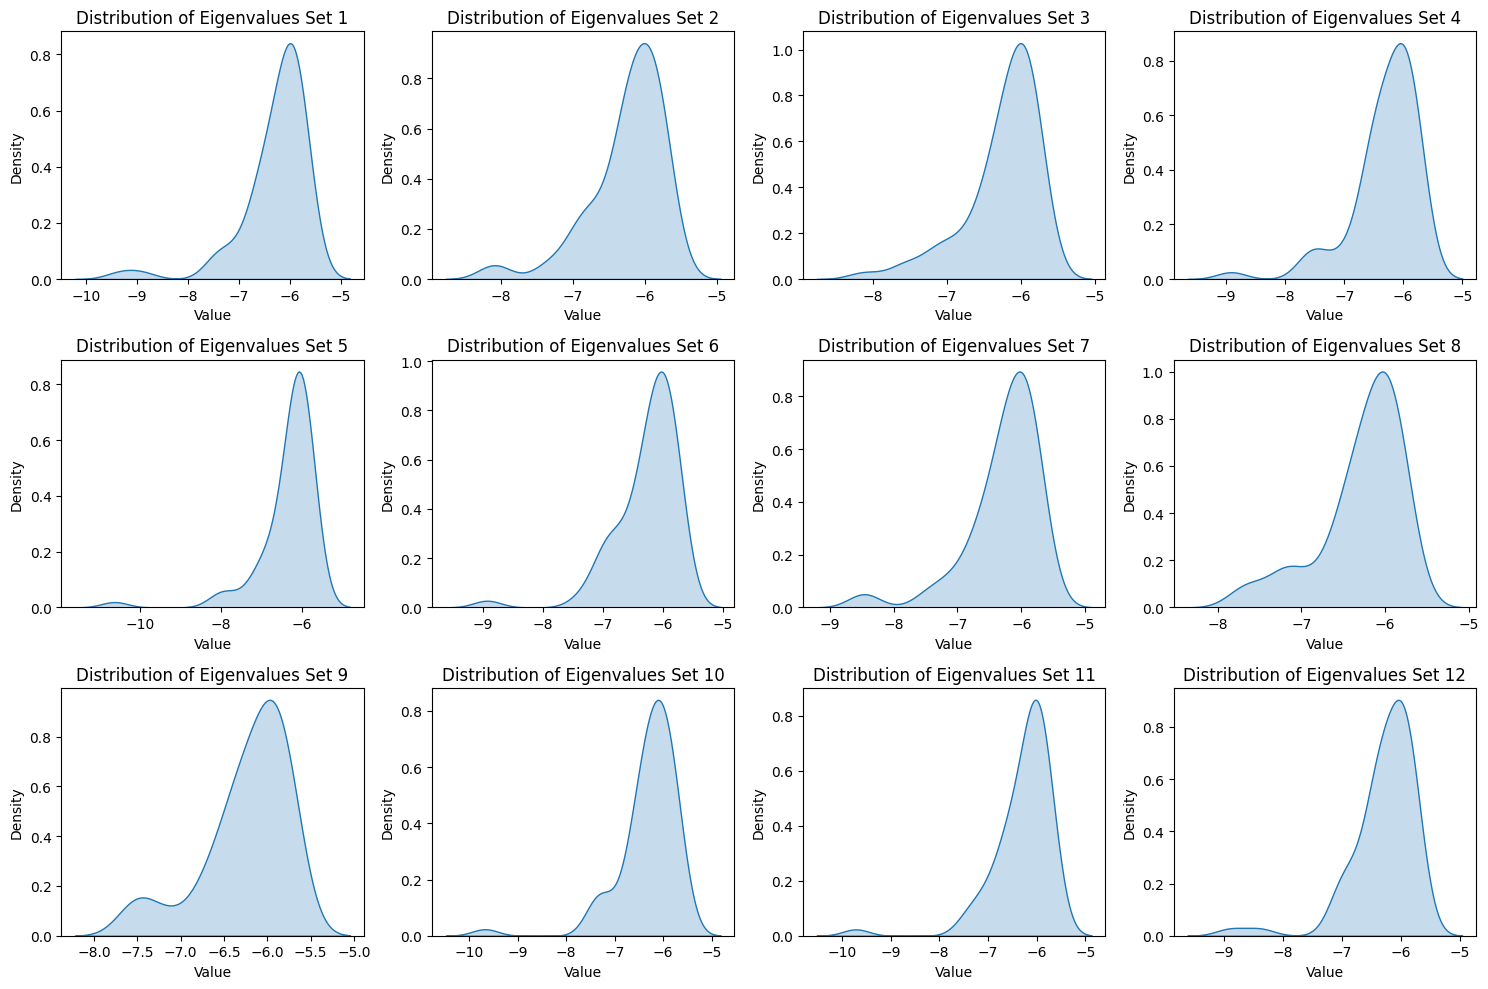

In [43]:
import seaborn as sns

# Adjusting the layout to 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Flattening the axes array for easy iteration
axes = axes.flatten()

for i in range(12):
    # Using seaborn to plot a distribution curve (density plot)
    sns.kdeplot(eigenvalues_qk_log[i, :].detach(), ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of Eigenvalues Set {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()
